### Figures and Analysis Presented in the Methodology Section

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.datasets import make_blobs
from scipy.spatial.distance import pdist, squareform
from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import gaussian_kde

from MINOV.novelty import compute_MI_novelty
from MINOV.density import compute_MI_density, get_MI_profile

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.ticker as ticker

from style import mpl_style

Custom matplotlib styles have been applied.


/Users/andrewf/miniconda3/envs/MINOV/lib/python3.10/site-packages/ElMD/ElMD.py:32: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


### Generate Synthetic Dataset

In [2]:
blob_params = [
    {"center": [0, 0], "std": 0.1, "random_state": 10},
    {"center": [1, 1], "std": 0.3, "random_state": 5},
    {"center": [2, 2], "std": 0.5, "random_state": 6},
    {"center": [2, 1], "std": 0.1, "random_state": 11},
]

# Generate all blobs and concatenate
X = np.vstack(
    [
        make_blobs(
            n_samples=20,
            centers=[params["center"]],
            cluster_std=params["std"],
            random_state=params["random_state"],
        )[0]
        for params in blob_params
    ]
)

# the sort order is applied so that points of higher density are plotted last and thus
# will appear on top of points of lower density in the scatter plot.

sort_order = np.array([18, 19, 15, 3, 13, 0, 11, 8, 5, 17, 9, 10, 4, 2, 6, 1, 14, 7, 
                       12, 16, 33, 30, 34, 23, 26, 38, 27, 29, 20, 37, 24, 35, 28, 39,
                       22, 32, 31, 36, 21, 25, 58, 49, 54, 56, 50, 53, 55, 47, 41, 57,
                       43, 42, 44, 52, 40, 46, 48, 59, 45, 51, 60, 79, 71, 70, 72, 68,
                       75, 62, 64, 73, 67, 61, 78, 69, 66, 74, 63, 76, 65, 77])

X = X[sort_order]

# shuffle the data
np.random.seed(42)
np.random.shuffle(X)

X_dm = squareform(pdist(X, metric="euclidean"))

#### Apply MI Method

In [3]:
cutoff, mi_profile = get_MI_profile(X_dm, 200)
print("cutoff", cutoff)
minov_dens, weight_function = compute_MI_density(X_dm, cutoff, mi_profile)

minov_dens = minov_dens / minov_dens.max() # normalize densities

# set to zero after cutoff
mask = np.linspace(0, np.max(X_dm), 200) <= cutoff
x = np.linspace(0, np.max(X_dm), 200)

cutoff 1.3390073106910452


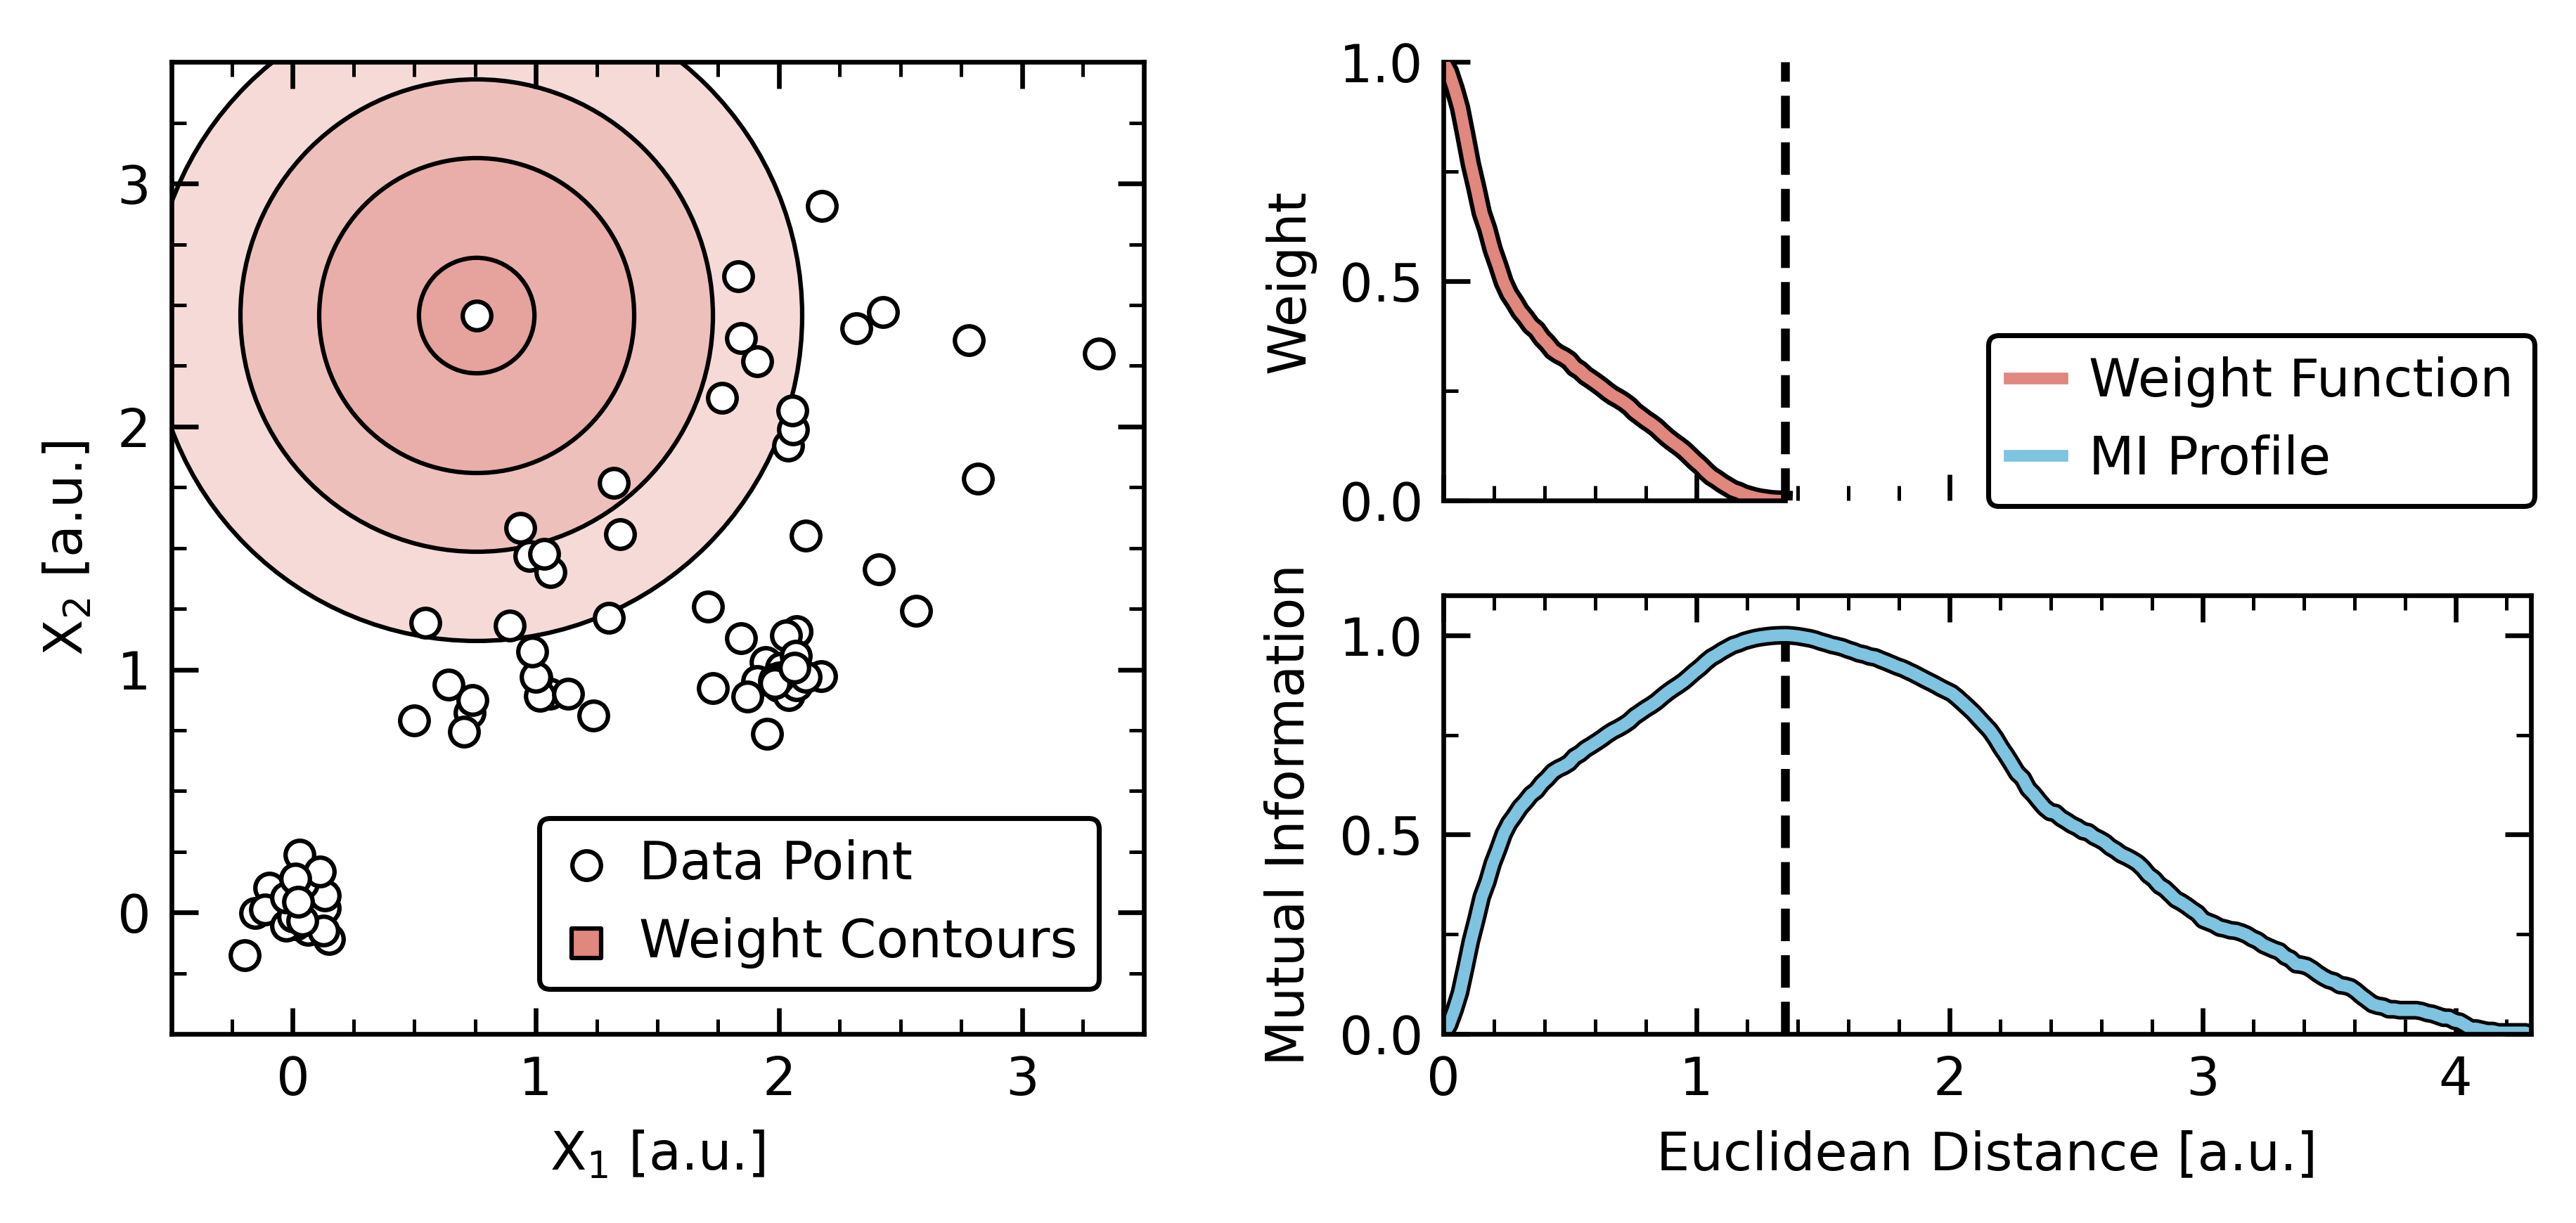

In [4]:
# Create figure
fig = plt.figure(figsize=(6.5, 3), dpi=600)

# Create grid specification
gs = gridspec.GridSpec(2, 2, figure=fig)

# Create axes with the left plot spanning both rows
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])

# Plot on the left axis (spanning both rows)
ax1.scatter(X[:, 0], X[:, 1], fc="w", ec="k", marker=".", s=95, label="Data Point", zorder=5, lw=0.75)
ax1.scatter([],[], marker='s', fc='#E0877E', ec='k', s=25, lw=0.75, label='Weight Contours')

radii_indices = [np.argmin(np.abs(weight_function - value)) for value in [0.0, 0.1, 0.25, 0.5]]
radii = [x[i] for i in radii_indices]

pt = 38
for rad in radii:
    circle = plt.Circle((X[pt, 0], X[pt, 1]), rad, color="#E0877E", ls='-', alpha=0.3, fill=True, ec="none")
    ax1.add_artist(circle)
for rad in radii:
    edge = plt.Circle((X[pt, 0], X[pt, 1]), rad, color="k", lw=0.75, ls='-', alpha=1.0, fill=False)
    ax1.add_artist(edge)

ax1.set_aspect('equal')
ax1.set_xlim(-0.5, 3.5)
ax1.set_ylim(-0.5, 3.5)
ax1.set_yticks([0, 1, 2, 3])
ax1.set_xticks([0, 1, 2, 3])
ax1.set_xlabel("X$_\mathrm{1}$ [a.u.]")
ax1.set_ylabel("X$_\mathrm{2}$ [a.u.]")
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(0.25))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(0.25))

legend = ax1.legend(frameon=True, framealpha=1, edgecolor="k",)
legend.get_frame().set_linewidth(0.85)

ax2.plot(x[mask], weight_function[mask], lw=3.5, color="k", zorder=1)
ax2.plot(x[mask], weight_function[mask], lw=2, color="#E0877E", zorder=2)

ax2.axvline(cutoff+0.01, color="k", lw=1.5, ls="--")
ax2.set_xlabel("Distance [a.u.]")
ax2.set_ylabel("Weight")
ax2.set_xlim(0, np.max(X_dm))
ax2.set_ylim(0.0, 1.0)
ax2.set_yticks([0, 0.5, 1])

#turn of top axis and right axis
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.xaxis.set_ticks_position('bottom')
ax2.yaxis.set_ticks_position('left')

ax2.spines['bottom'].set_bounds(0, cutoff+0.01)
ax2.set_xticks([])
ax2.yaxis.set_minor_locator(ticker.MultipleLocator(0.25))

ax2.plot([],[], color='#E0877E', label="Weight Function")
ax2.plot([],[], color='#7EC3E0', label="MI Profile")
legend = ax2.legend(frameon=True, framealpha=1, edgecolor="k", loc='lower left', bbox_to_anchor=(0.46, -0.115))
legend.get_frame().set_linewidth(0.85)

# Plot on the top right axis
ax3.vlines(cutoff+0.01, 0.0, 1.0, color="k", lw=1.5, ls="--")
ax3.plot(x, mi_profile, lw=3.2, color="k")
ax3.plot(x, mi_profile/np.max(mi_profile), color="#7EC3E0", lw=2)
ax3.set_ylabel("Mutual Information")
ax3.set_xlim(0, np.max(X_dm))
ax3.set_ylim(0, 1.1)
ax3.set_yticks([0, 0.5, 1])
ax3.yaxis.set_minor_locator(ticker.MultipleLocator(0.25))

# Share x-axis between the right plots
ax2.sharex(ax3)
# Remove x-tick labels from the top plot since they're shared
ax2.tick_params(axis='x', labelbottom=False)
# Move x-label to the bottom plot
ax2.set_xlabel('')
ax3.set_xlabel("Euclidean Distance [a.u.]")

plt.tight_layout()
plt.show()

### Compare weight function to normalized average of normal distributions

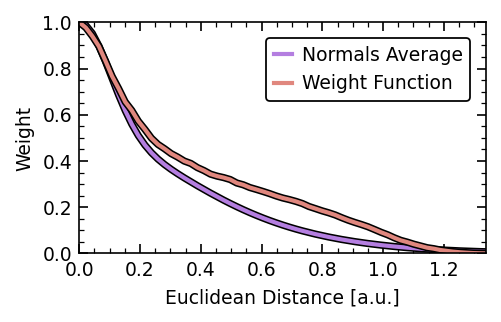

In [5]:
from scipy.stats import halfnorm

# List of sigma values for half normal distributions
sigmas = [0.1, 0.3, 0.5, 0.1]

# Create x values
x = np.linspace(0, np.max(X_dm), 200)
# get index where x == cutoff
cutoff_index = np.where(x == cutoff)[0][0]

# Initialize sum of PDFs
pdf_sum = np.zeros_like(x)

# Plot each distribution and add to sum
for i, sigma in enumerate(sigmas):
    pdf = halfnorm.pdf(x, scale=sigma)
    pdf_sum += pdf/np.max(pdf)

pdf_sum = pdf_sum / len(sigmas)
pdf_sum /= np.max(pdf_sum)

fig, ax = plt.subplots(figsize=(3.5, 2), dpi=150)
ax.plot(x, pdf_sum, color='k', linewidth=3.5,)
ax.plot(x, pdf_sum, color='#B47EE0', linewidth=2, label='Normals Average')

ax.plot(x[mask], weight_function[mask], lw=3.5, color="k")
ax.plot(x[mask], weight_function[mask], lw=2, color="#E0877E", label="Weight Function")
plt.xlim(0, cutoff)
plt.ylim(0, 1)
plt.xlabel("Euclidean Distance [a.u.]")
plt.ylabel("Weight")


legend = ax.legend(frameon=True, framealpha=1, edgecolor="k",)
legend.get_frame().set_linewidth(0.85)

plt.show()

#### Apply KDE Method

In [6]:
def compute_kde_density(distance_matrix):
    """
    Fit a gloabl bandwidth and compute KDE density for each row in a distance matrix.
    """
    all_dist = distance_matrix[np.triu_indices(len(distance_matrix), k=1)]
    kde_all = gaussian_kde(all_dist, bw_method='silverman')
    global_bandwidth = kde_all.covariance_factor() * np.std(all_dist, ddof=1)

    print(f"Global Bandwidth: {global_bandwidth}")

    kde_dens = []
    for row in distance_matrix:
        non_zero = row[row > 0]
        reflected_data = np.concatenate([non_zero, -non_zero])
        kde = gaussian_kde(reflected_data, bw_method=global_bandwidth)
        kde_dens.append(kde.evaluate(0)[0])

    return np.array(kde_dens)

kde_dens = compute_kde_density(X_dm)
kde_dens = kde_dens / kde_dens.max()  # normalize to [0, 1] for colorbar

Global Bandwidth: 0.18819023008910618


#### Apply KNN Approach

In [7]:
def compute_knn_density(distance_matrix, k=10):
    """
    Compute KNN density for each row of a distance matrix based on the average distance
    to its k-nearest neighbors.
    """
    knn_dens = []
    for row in distance_matrix:
        knn_distances = np.sort(row[row > 0])[:k]  # Get the k-nearest nonzero distances
        knn_density = 1.0 / (np.mean(knn_distances) + 1e-10)  # Avoid division by zero
        knn_dens.append(knn_density)
    
    return np.array(knn_dens)

print("Num Neighbors: ", int((4 / (3 * len(X_dm))) ** (1 / 5) * len(X_dm)))

knn_dens = compute_knn_density(X_dm, k=int((4 / (3 * len(X_dm))) ** (1 / 5) * len(X_dm))) # silvermans rule
knn_dens = knn_dens / knn_dens.max()  # normalize to [0, 1] for colorbar

Num Neighbors:  35


#### Apply Local Outlier Factor 

In [8]:
def compute_lof_density(distance_matrix, n_neighbors=20):
    """
    Compute LOF density for each row in a distance matrix.
    """

    lof = LocalOutlierFactor(n_neighbors=n_neighbors, metric="precomputed")
    lof.fit(distance_matrix)


    return lof.negative_outlier_factor_

lof_dens = compute_lof_density(X_dm, n_neighbors=int((4 / (3 * len(X_dm))) ** (1 / 5) * len(X_dm))) # silvermans rule


In [9]:
def plot_density(X, dens, axs, **kwargs):

    axs.scatter(
        X[:, 0],
        X[:, 1], 
        c=dens, 
        marker=".", 
        s=95, 
        cmap="rainbow", 
        ec="k", 
        lw=0.75, 
        label="Data Point", 
        vmin=0,
        vmax=1,
        **kwargs
    )

    axs.set_aspect('equal')

    for i, d in enumerate(np.argsort(dens)[:5]):
        axs.annotate(
            f"{i+1}", 
            # f"{np.round(dens[d], 5)}", 
            (X[d, 0], X[d, 1] + 0.15), 
            color="k", 
            fontsize=7, 
            weight="bold", 
            ha="center"
        )

    axs.scatter([],[], marker='$\mathrm{1}$', color='k', s=25, label='Density Rank')

    plt.xlim(-0.65, 3.65)
    plt.ylim(-0.65, 3.65)
    plt.yticks([0,1,2,3])
    plt.xticks([0,1,2,3])

    return axs

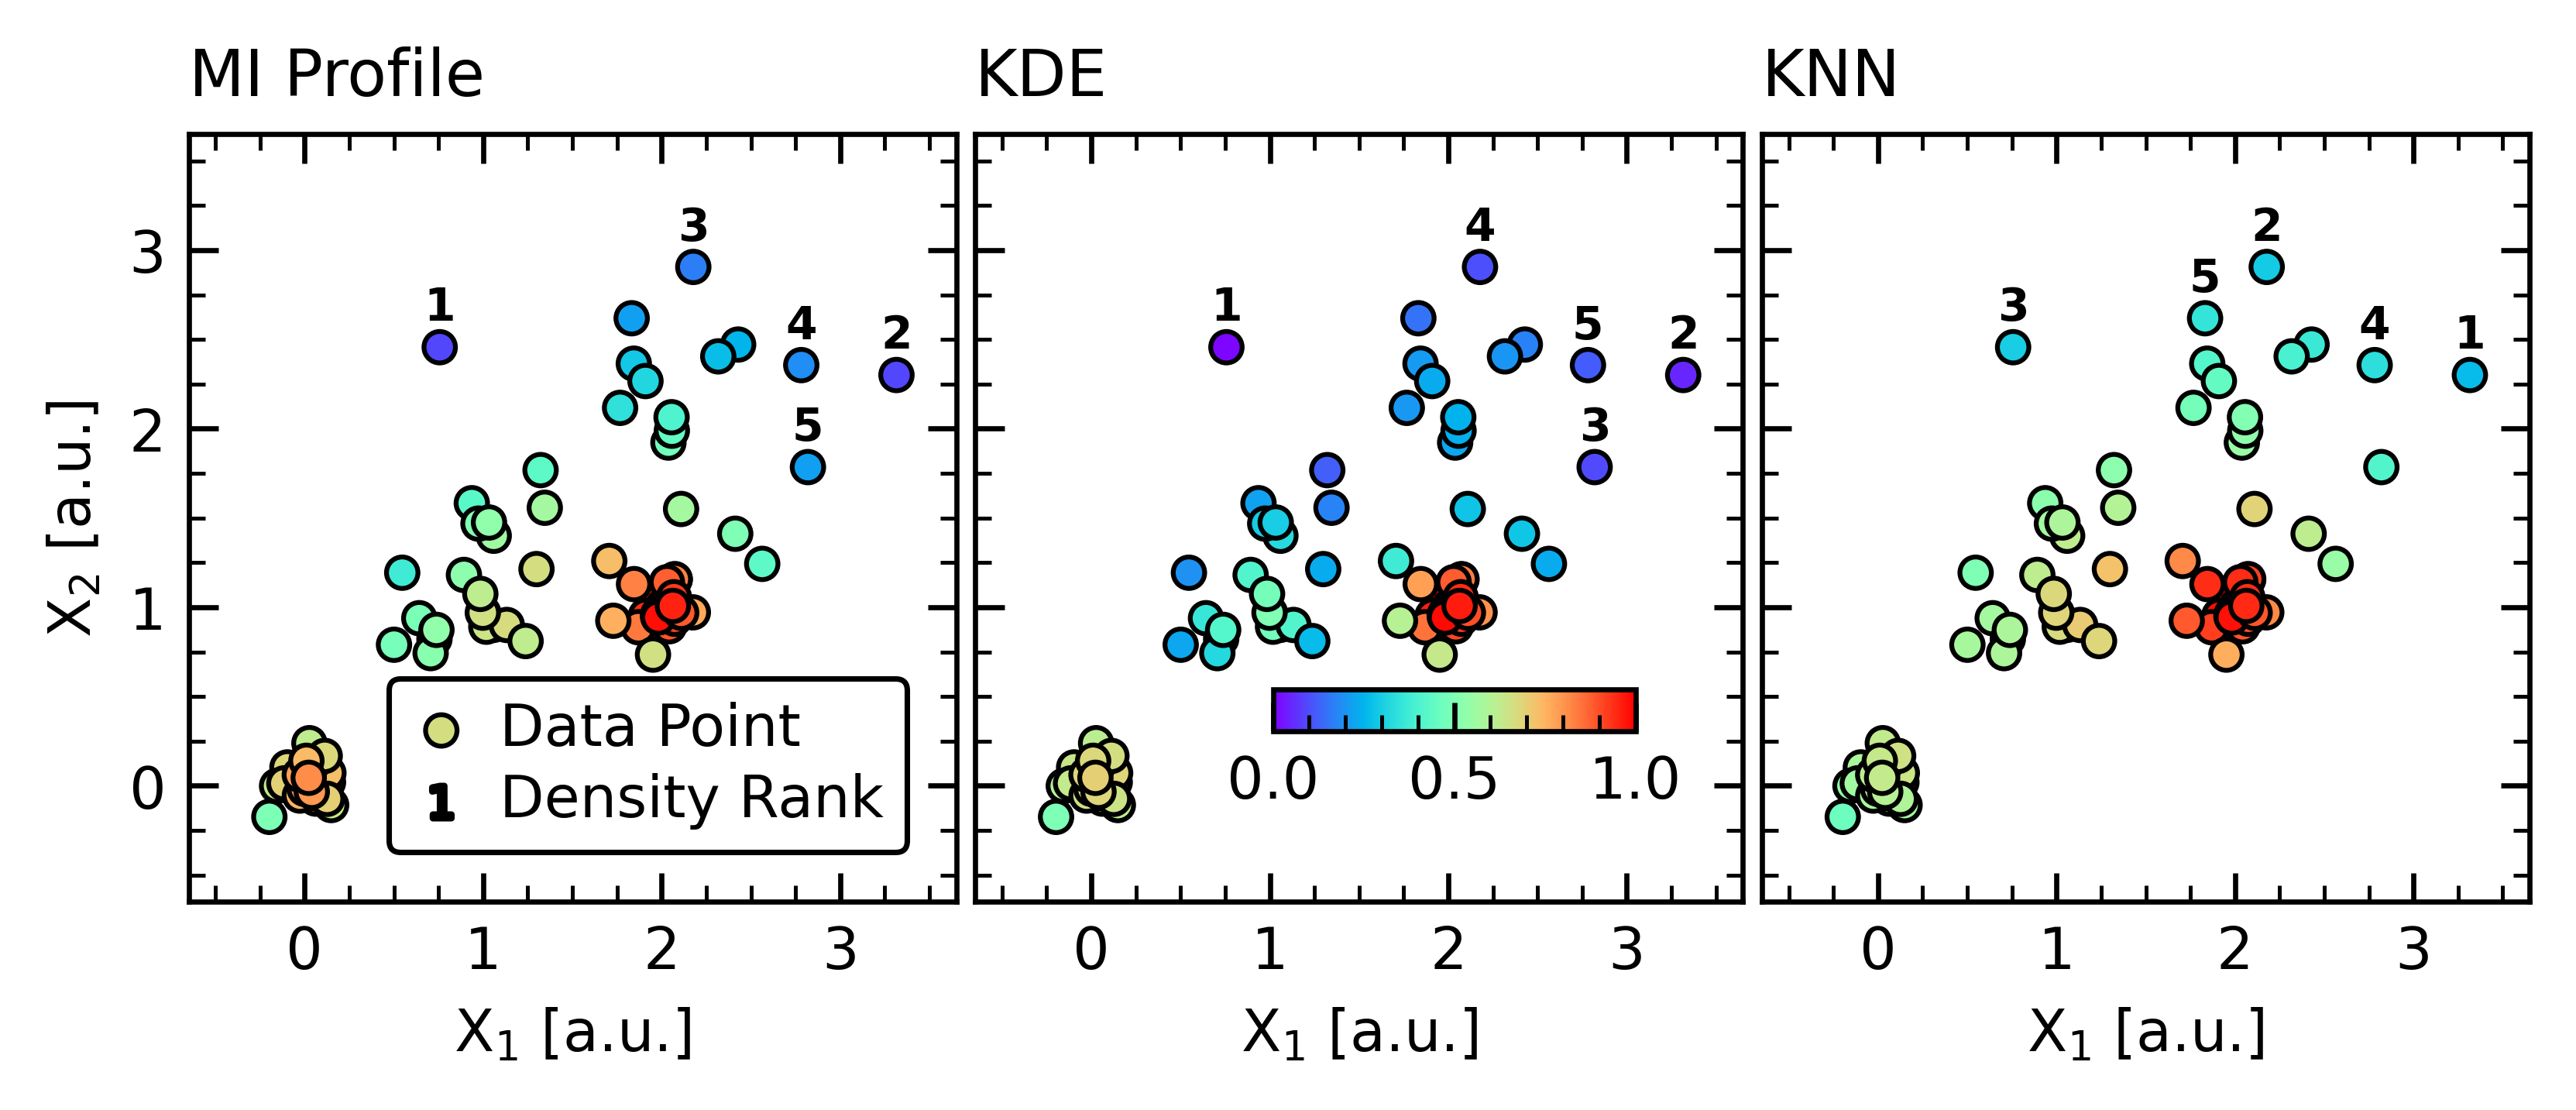

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(6.5, 3), sharex=True, sharey=True, dpi=600)

plt.subplots_adjust(wspace=0.025, hspace=0.15)

# MINOV
plot_density(X, minov_dens, axs=ax[0])
ax[0].set_title("MI Profile", fontsize=10, loc='left')
ax[0].yaxis.set_minor_locator(ticker.MultipleLocator(0.25))
ax[0].xaxis.set_minor_locator(ticker.MultipleLocator(0.25))

# KDE
plot_density(X, kde_dens, axs=ax[1])
ax[1].set_title("KDE", fontsize=10, loc='left')
ax[1].yaxis.set_minor_locator(ticker.MultipleLocator(0.25))
ax[1].xaxis.set_minor_locator(ticker.MultipleLocator(0.25))


# KNN
plot_density(X, knn_dens, axs=ax[2])
ax[2].set_title("KNN", fontsize=10, loc='left')
ax[2].yaxis.set_minor_locator(ticker.MultipleLocator(0.25))
ax[2].xaxis.set_minor_locator(ticker.MultipleLocator(0.25))

# LOF
# plot_dummy_density(X, lof_dens, axs=ax[1,1])
# ax[1,1].set_title("Local Outlier Factor", fontsize=10, loc='left')

# add x and y labels to outer edges
ax[0].set_xlabel("X$_\mathrm{1}$ [a.u.]")
ax[1].set_xlabel("X$_\mathrm{1}$ [a.u.]")
ax[2].set_xlabel("X$_\mathrm{1}$ [a.u.]")

ax[0].set_ylabel("X$_\mathrm{2}$ [a.u.]")

# legend = ax[0].legend(frameon=True, framealpha=1, edgecolor="k", loc='lower right', bbox_to_anchor=(-0.056, -0.45), ncols=1, columnspacing=0.5)
legend = ax[0].legend(frameon=True, framealpha=1, edgecolor="k", loc='lower right', labelspacing=0.25)
legend.get_frame().set_linewidth(0.85)

cax = fig.add_axes([0.484, 0.342, 0.12, 0.03])  # Adjust these values to position your colorbar
cbar = fig.colorbar(mappable=ax[2].collections[0], cax=cax, orientation='horizontal')

plt.show()
